# Thực hành về mạng GAN

In [17]:
# !nvidia-smi
# from google.colab import drive
# drive.mount('/content/drive')
# !pip3 install torchsummary
# !pip3 install torchvision

### Chuẩn bị các thư viện cần thiết

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import cv2
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms

from torch.nn import CrossEntropyLoss, Dropout, Softmax, Linear, Conv2d, LayerNorm
import matplotlib.pyplot as plt
from torchsummary import summary

### Thiết lập các hằng số cho tập MNIST

In [24]:
width    = 28
height   = 28
channels = 1
epochs   = 1000

img_shape = (width, height, channels)

<H2>1. Tải tập dữ liệu MNIST</H2>

Ta chỉ dùng tập huấn luyện, không dùng nhãn. Các điểm ảnh được chuẩn hoá về miền giá trị [-1, 1] 

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

batch_size = 32

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Trực quan dữ liệu MNIST

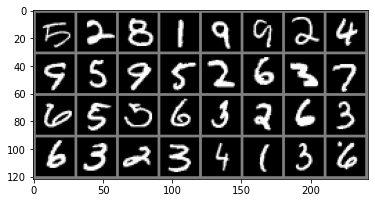

    5     2     8     1     9     9     2     4     9     5     9     5     2     6     3     7     6     5     5     6     3     2     6     3     6     3     2     3     4     1     3     6


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % labels[j].item() for j in range(batch_size)))

<H2>2. Generator</H2>
Lập trình kiến trúc Generator theo mô tả phía dưới

In [ ]:
""" Declare GENERATOR. 
    + Its input is a 100-feature vector of random noise
    + Its output is a fake image with pixel values in [-1, 1]"""

class Generator(nn.Module):
    
    ##########################
    ###   YOUR CODE HERE   ###
    ##########################
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100 ,256),
            nn.BatchNorm1d(256),
            nn.LeakyReLu(),

            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),

            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(),

            nn.Linear(1024, width * height * channels),
            nn.Tanh()
        )
    def forward(self, x):
        x = self.model(x)
        return x.view(-1, width, height, channels)


G = Generator().cuda()
summary(G, (100, ), batch_size=-1, device='cuda')
print("_____________________ Generator Created_____________________")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 256]          25,856
         LeakyReLU-2                  [-1, 256]               0
       BatchNorm1d-3                  [-1, 256]             512
            Linear-4                  [-1, 512]         131,584
         LeakyReLU-5                  [-1, 512]               0
       BatchNorm1d-6                  [-1, 512]           1,024
            Linear-7                 [-1, 1024]         525,312
         LeakyReLU-8                 [-1, 1024]               0
       BatchNorm1d-9                 [-1, 1024]           2,048
           Linear-10                  [-1, 784]         803,600
             Tanh-11                  [-1, 784]               0
Total params: 1,489,936
Trainable params: 1,489,936
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forw

<H2>3. Discriminator</H2>
Lập trình kiến trúc Discriminator

In [ ]:
""" Declare DISCRIMINATOR 
    Its input is REAL IMAGE (in a form of a vector 28x28)
    Its ouput is the probability of image type (REAL IMAGE or FAKE IMAGE)
    the values in the range of [0, 1] """

class Discriminator(nn.Module):
    ##########################
    ###   YOUR CODE HERE   ###
    ##########################
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(width*height*channels, width*height*channels),
            nn.LeakyReLU(),
            nn.Linear(width*height*channels, (width*height*channels)//2),
            nn.LeakyReLU(),
            nn.Linear((width*height*channels)//2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

D = Discriminator().cuda()
summary(D, img_shape, batch_size=-1, device='cuda')
print("____________________ Discriminator Created____________________")


<h2>4. Generative model</h2>

Xây dựng GAN và huấn luyện

In [ ]:
##########################
###   YOUR CODE HERE   ###
##########################
optimizer_G = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=8e-8)
optimizer_D = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999), weight_decay=8e-8)

epochs        = 1000
adversarial_loss = nn.BCELoss().cuda()


losses_G = []
losses_D = []
samples = []

In [ ]:
for epoch in range(epochs):
    for (i, (imgs, _)) in enumerate(trainloader, start=1):
        # Adversarial ground truths
        valid = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0), requires_grad=False)

        # Configure input
        real_imgs = imgs.to(device=device, dtype=torch.float32)


        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()

        # Sample noise as generator input
        z = Variable(torch.cuda.FloatTensor(np.random.normal(0, 1, (imgs.shape[0], 100))))

        # Generate a batch of images
        gen_imgs = G(z)

        # Loss measures generator's ability to fool the discriminator

        ##########################
        ###   YOUR CODE HERE   ###
        ##########################
        g_loss = adversarial_loss(D(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Loss measures discriminator's ability to classify real from generated samples

        ##########################
        ###   YOUR CODE HERE   ###
        ##########################
        real_loss = adversarial_loss(D(real_imgs), valid)
        fake_loss = adversarial_loss(D(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        optimizer_D.step()

        if epoch % 10 == 0 and i == len(trainloader):
            print(
                "[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"
                % (epoch, epochs, i, len(trainloader), d_loss.item(), g_loss.item())
            )
            
            losses_G.append(g_loss.item())
            losses_D.append(d_loss.item())
            samples.append(gen_imgs)


[Epoch 0/1000] [Batch 1875/1875] [D loss: 0.567250] [G loss: 0.849551]
[Epoch 10/1000] [Batch 1875/1875] [D loss: 0.615487] [G loss: 0.989828]
[Epoch 20/1000] [Batch 1875/1875] [D loss: 0.644482] [G loss: 0.857566]
[Epoch 30/1000] [Batch 1875/1875] [D loss: 0.449982] [G loss: 1.188688]
[Epoch 40/1000] [Batch 1875/1875] [D loss: 0.435769] [G loss: 1.717387]
[Epoch 50/1000] [Batch 1875/1875] [D loss: 0.545302] [G loss: 0.907160]
[Epoch 60/1000] [Batch 1875/1875] [D loss: 0.604432] [G loss: 1.368047]
[Epoch 70/1000] [Batch 1875/1875] [D loss: 0.473351] [G loss: 1.126326]
[Epoch 80/1000] [Batch 1875/1875] [D loss: 0.516999] [G loss: 1.188379]
[Epoch 90/1000] [Batch 1875/1875] [D loss: 0.458347] [G loss: 1.528381]
[Epoch 100/1000] [Batch 1875/1875] [D loss: 0.534393] [G loss: 1.319414]
[Epoch 110/1000] [Batch 1875/1875] [D loss: 0.425020] [G loss: 1.788332]
[Epoch 120/1000] [Batch 1875/1875] [D loss: 0.480867] [G loss: 1.442632]
[Epoch 130/1000] [Batch 1875/1875] [D loss: 0.338395] [G loss:

### Vẽ đồ thị hàm loss huấn luyện

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(losses_G)/10)*10), losses_G, label="G_loss")
plt.plot(list(range(len(losses_D)/10)*10), losses_D, label="D_loss")
plt.title("Training losses", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Losses", fontsize=14)
plt.legend(loc="upper right", fontsize=14)
plt.show()

### Trực quan hoá kết quả sinh dữ liệu của mô hình đã huấn luyện

In [ ]:
i = 0
for i in range(0, len(samples), 10):
    images = samples[i].data.cpu().numpy()
    print("    ____________________ Step = %d ____________________" % i*10)
    plt.figure(figsize=(6, 6))
    for i in range(16):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print("\n")

In [ ]:
noise = torch.Tensor(np.random.normal(0, 1, (16, 100))).cuda()
gen_images = G(noise)
images = gen_images.data.cpu().numpy()
plt.figure(figsize=(6, 6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [height, width])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()